<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_predict
from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15,4)

## Подготовка

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.index.is_monotonic_increasing

True

Данные отсортированы хронологически верно

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Последние данные датированы 31 августа 2018 года. Выполним ресемлирование по 1 часу:

In [6]:
df = df.resample('1H').sum()

**Вывод:**

Данные подготовили к анализу. Аномалий и пропущенных значений не выявленно.

## Анализ

Посмотрим скользащее среднее и скользящее стандартное отклонение:

In [7]:
df_copy = df.copy()

In [8]:
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(24).mean()
df_copy['rolling_std'] = df_copy['num_orders'].shift().rolling(24).std()
df_copy = df_copy.dropna()

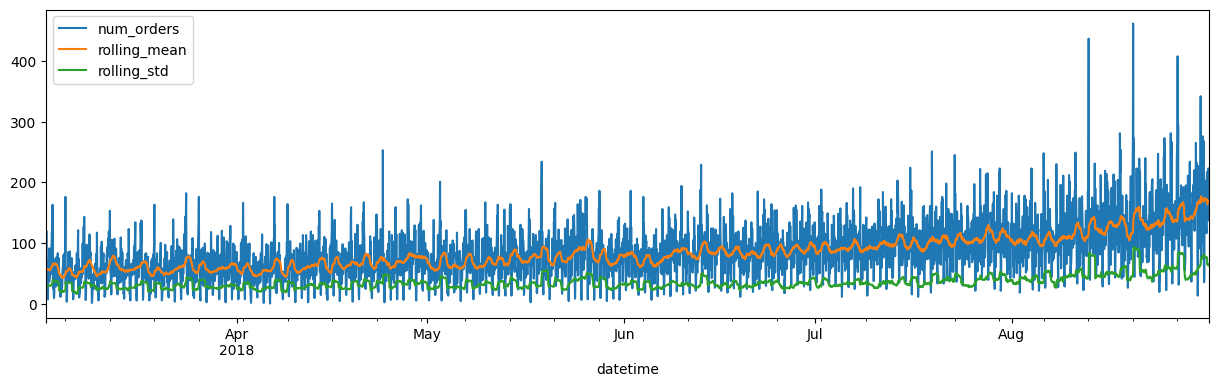

In [9]:
df_copy.plot();

Изначально выборка достаточно стационарна, посмотрим ли сильно измениться ситуация, если получить разность ряда:

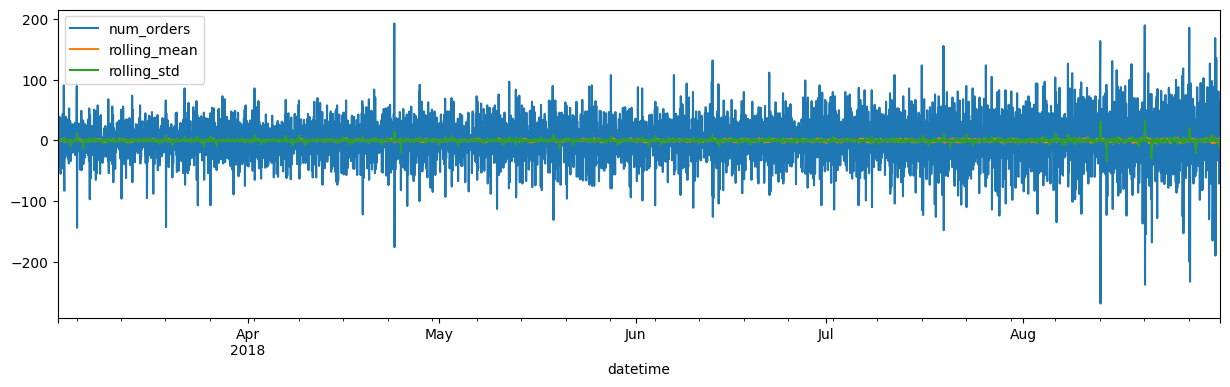

In [10]:
df_copy_shift = df_copy - df_copy.shift()
df_copy_shift.dropna(inplace=True)
df_copy_shift.plot();

Временной ряд стал стационарным. Теперь рассмотрим тренд, сезонность и остаток:

Выдвинем ряд гипотез:

- Н0 (нулевая гипотеза): единичные корни отсутствуют (ряд стационарен);
- НА (альтернативная гипотеза): временной ряд имеет единичные корни (ряд не стационарен).

Проверим гипотезы с помощью теста Дики-Фуллера (ADF):

In [11]:
from statsmodels.tsa.stattools import adfuller

st_test = adfuller(df['num_orders'], regression='ctt')

print('adf: {}'.format(st_test[0]))
print('p-value: {}'.format(st_test[1]))
print('Критические значения:')
for k, v in st_test[4].items():
    print('\t{}: {}'.format(k, v))
print()

if st_test[0] > st_test[4]['5%']:
    print('Нулевая гипотеза отвергнута – Временной ряд не стационарен')
else:
    print('Нулевая гипотеза не отвергнута – Временной ряд стационарен')

adf: -10.891452237749148
p-value: 4.054939789240617e-17
Критические значения:
	1%: -4.373775161444573
	5%: -3.8337377543683258
	10%: -3.554095038926073

Нулевая гипотеза не отвергнута – Временной ряд стационарен


In [12]:
decomposed = seasonal_decompose(df_copy['num_orders'])

In [13]:
def make_chart(df, title):
    sns.lineplot(data=df)
    plt.title(title)
    plt.show()

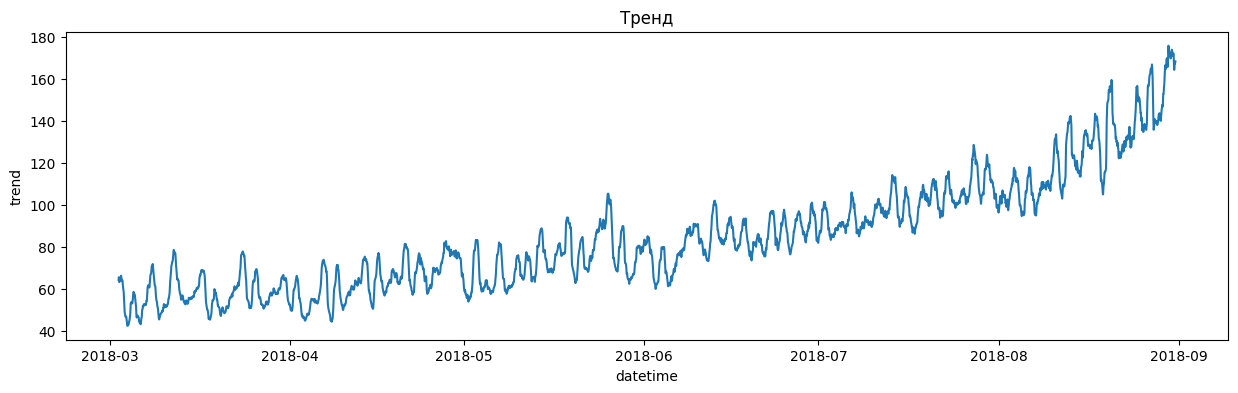

In [14]:
make_chart(decomposed.trend, 'Тренд')

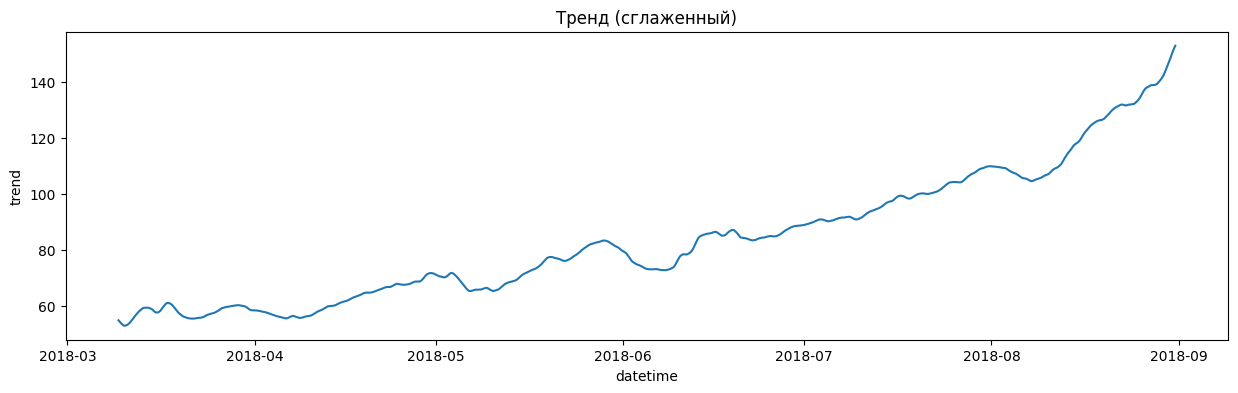

In [15]:
make_chart(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

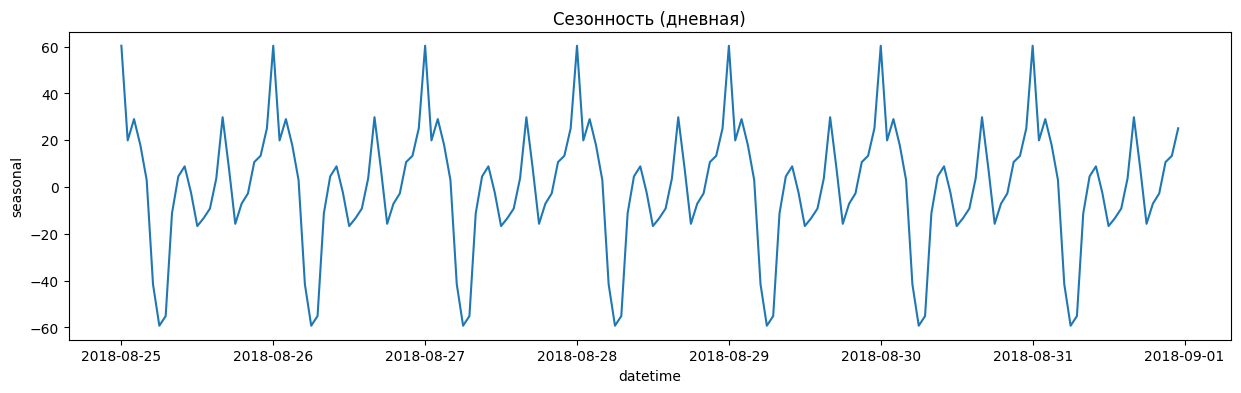

In [16]:
make_chart(decomposed.seasonal.tail(24*7), 'Сезонность (дневная)')

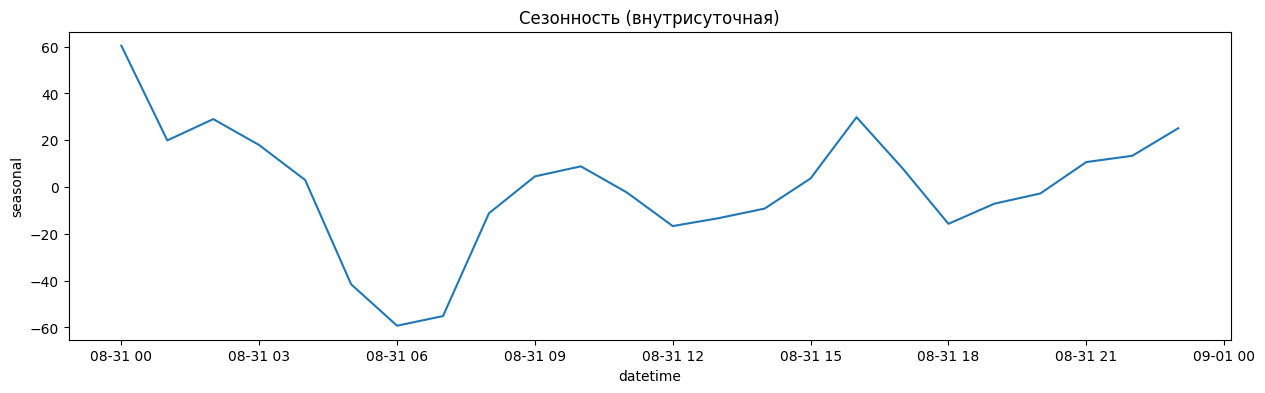

In [17]:
make_chart(decomposed.seasonal.tail(24), 'Сезонность (внутрисуточная)')

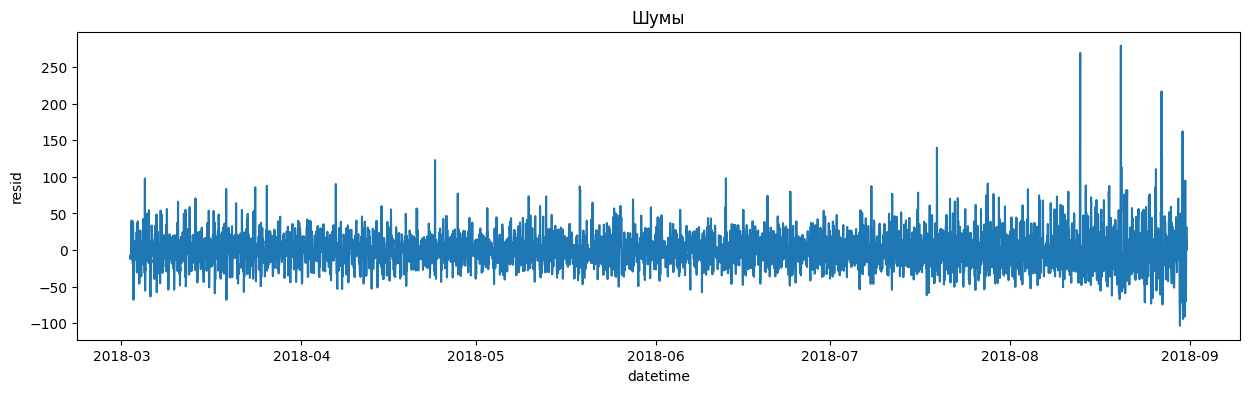

In [18]:
make_chart(decomposed.resid, 'Шумы')

**Вывод:**

- на графике "Тренд" можно увидеть, что количество заказов постепенно увеличивается;
- на графике "Сезонность (дневная)" видно, что в течение недели график не меняется, значит зависимости количества заказов от дня недели нет;
- на графике "Сезонность (внутрисуточная)" видно, что ближе к ночи количество заказов увеличивается, ночью спадает, также есть небольшой пик заказов в 16 часов.

## Обучение

Создадим признаки:

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data_foo = data.copy()
    data_foo['month'] = data_foo.index.month
    data_foo['dayofweek'] = data_foo.index.dayofweek
    data_foo['hour'] = data_foo.index.hour
    
    for lag in range(1, max_lag + 1):
        data_foo['lag_{}'.format(lag)] = data_foo['num_orders'].shift(lag)

    data_foo['rolling_mean'] = data_foo['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_foo

In [20]:
df_model = make_features(df, 2, 24)

Разделим данные на выборки:

In [21]:
train, test = train_test_split(df_model, shuffle=False, test_size=0.1)
train = train.dropna()

In [22]:
f_train = train.drop(['num_orders'], axis=1)
t_train = train['num_orders']

f_test = test.drop(['num_orders'], axis=1)
t_test = test['num_orders']

Создадим функции для построения определения лучших гиперпараметров, построении и обучении модели и выводу графиков:

In [23]:
def best_param(model, f_train, t_train, params):
    start = time.time()
    
    grid = GridSearchCV(model, params, cv=TimeSeriesSplit(n_splits=10), scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(f_train, t_train)
    end = time.time()

    b_time = end - start

    return grid.best_params_, b_time

In [24]:
def calculation(model, f_train, t_train, f_val, t_val, params, p_start, p_stop, flag=False):
    model_type = {
        'lr': LinearRegression,
        'rfr': RandomForestRegressor,
        'cbr': CatBoostRegressor,
        'lgbmr': LGBMRegressor
    }
    
    if flag:
        best_par = params
        par_time = 0
    else:
        best_par, par_time = best_param(model_type[model](), f_train, t_train, params)
    start = time.time()
    best_model = model_type[model](**best_par)
    best_model.fit(f_train, t_train)
    end = time.time()
    model_time = end - start
    
    start = time.time()
    if flag:
        pred_target = best_model.predict(f_val)
    else:
        pred_target = cross_val_predict(best_model, f_val, t_val, cv=10)
    end = time.time()
    pred_time = end - start
    
    rmse = mean_squared_error(t_val, pred_target) ** .5
    
    table = PrettyTable()
    table.field_names = ['Данные', 'Значение']
    table.add_row(['Подбор параметров', f'{par_time // 60} мин {(par_time % 60):.2f} сек'])
    table.add_row(['Обучение модели', f'{model_time:.2f} сек'])
    table.add_row(['Предсказание модели', f'{pred_time:.2f} сек'])
    table.add_row(['RMSE', f'{rmse}'])
    table.add_row([' ', ' '])
    table.add_row(['Лучшие параметры:', ' '])
    for k, v in best_par.items():
        table.add_row([f'{k}:', v])
    print(table)
    
    graf = t_val.copy()
    pred_df = pd.DataFrame(data=pred_target, columns=['predictions'], index=f_val.index)
    df_graf = pd.merge(graf, pred_df, how='left', left_index = True, right_index = True)
    df_graf['predictions'] = df_graf['predictions'].astype('int64')
    df_graf[p_start:p_stop].plot()
    
    return best_model, rmse, model_time, pred_time

In [25]:
STATE = np.random.RandomState(15243)

### LinearRegression

+---------------------+--------------------+
|        Данные       |      Значение      |
+---------------------+--------------------+
|  Подбор параметров  |  0.0 мин 0.08 сек  |
|   Обучение модели   |      0.00 сек      |
| Предсказание модели |      0.03 сек      |
|         RMSE        | 30.833487752570722 |
|                     |                    |
|  Лучшие параметры:  |                    |
|    fit_intercept:   |        True        |
|      positive:      |        True        |
+---------------------+--------------------+
CPU times: total: 109 ms
Wall time: 126 ms


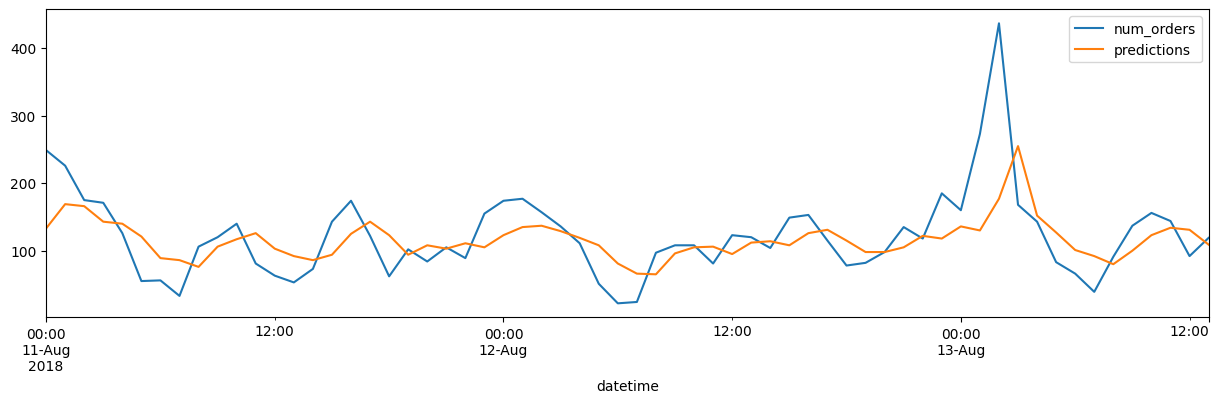

In [27]:
%%time

params = {'fit_intercept': [True, False], 'positive': [True, False]}
lr_model, lr_model_rmse, lr_model_time, lr_pred_time = calculation('lr',
                                                                   f_train,
                                                                   t_train,
                                                                   f_train,
                                                                   t_train,
                                                                   params,
                                                                   '2018-08-11',
                                                                   '2018-08-13')

### RandomForestRegressor

+---------------------+----------------------+
|        Данные       |       Значение       |
+---------------------+----------------------+
|  Подбор параметров  |  2.0 мин 43.95 сек   |
|   Обучение модели   |       1.95 сек       |
| Предсказание модели |      18.59 сек       |
|         RMSE        |  23.493346325749954  |
|                     |                      |
|  Лучшие параметры:  |                      |
|      max_depth:     |          10          |
|    n_estimators:    |         150          |
|    random_state:    | RandomState(MT19937) |
+---------------------+----------------------+
CPU times: total: 26.6 s
Wall time: 3min 4s


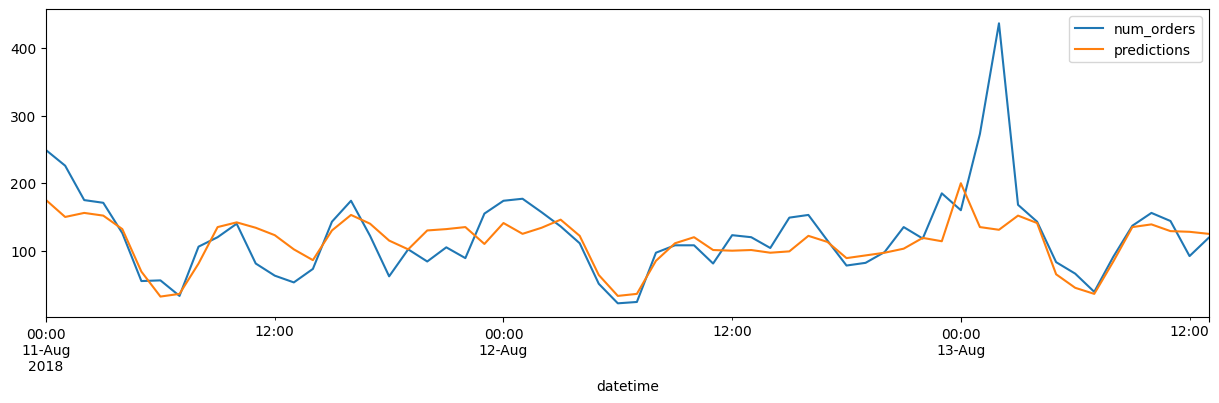

In [28]:
%%time

params = {'n_estimators':[x for x in range(10, 201, 10)],
          'max_depth':[x for x in range(2, 11)],
          'random_state':[STATE]}
rfr_model, rfr_model_rmse, rfr_model_time, rfr_pred_time = calculation('rfr',
                                                                       f_train,
                                                                       t_train,
                                                                       f_train,
                                                                       t_train,
                                                                       params,
                                                                       '2018-08-11',
                                                                       '2018-08-13')

### CatBoostRegressor

+---------------------+-------------------+
|        Данные       |      Значение     |
+---------------------+-------------------+
|  Подбор параметров  | 1.0 мин 52.00 сек |
|   Обучение модели   |      0.75 сек     |
| Предсказание модели |      7.27 сек     |
|         RMSE        | 21.95243506660677 |
|                     |                   |
|  Лучшие параметры:  |                   |
|        depth:       |         4         |
|    learning_rate:   |        0.1        |
|    random_state:    |       15243       |
|       verbose:      |       False       |
+---------------------+-------------------+
CPU times: total: 58.3 s
Wall time: 2min


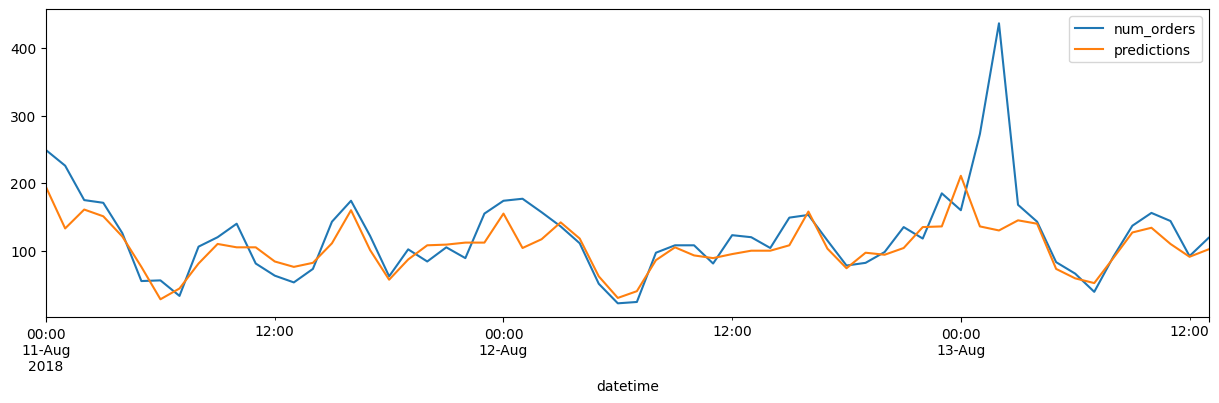

In [30]:
%%time

params = {'learning_rate':[0.1, 0.5, 0.8],
          'depth': [4, 6, 10],
          'verbose':[False],
          'random_state':[15243]}
cbr_model, cbr_model_rmse, cbr_model_time, cbr_pred_time = calculation('cbr',
                                                                       f_train,
                                                                       t_train,
                                                                       f_train,
                                                                       t_train,
                                                                       params,
                                                                       '2018-08-11',
                                                                       '2018-08-13')

### LGBMRegressor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 6
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

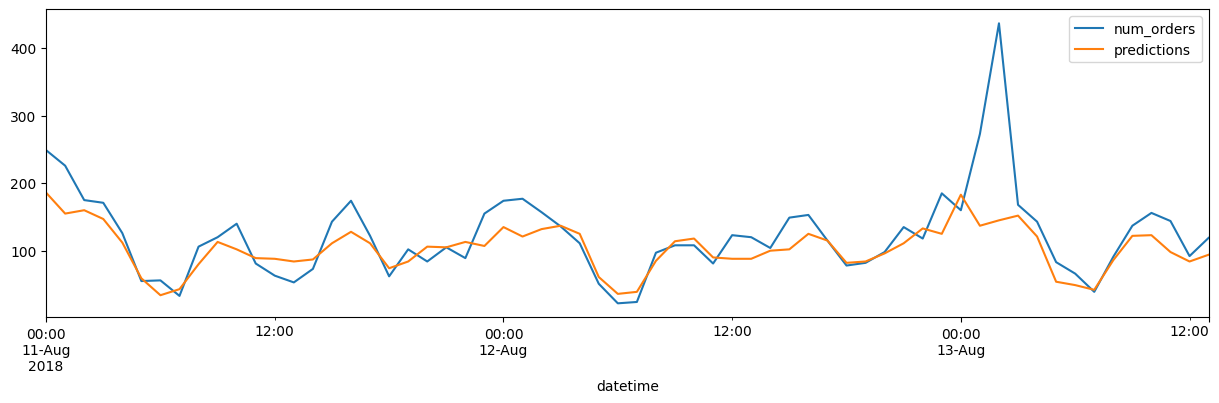

In [31]:
%%time

params = {'num_leaves':[31, 100, 200],
          'learning_rate':[0.1],
          'n_estimators':[50, 100, 200, 300],
          'random_state':[STATE]}
lgbmr_model, lgbmr_model_rmse, lgbmr_model_time, lgbmr_pred_time = calculation('lgbmr',
                                                                               f_train,
                                                                               t_train,
                                                                               f_train,
                                                                               t_train,
                                                                               params,
                                                                               '2018-08-11',
                                                                               '2018-08-13')

Выведем общую информацию:

In [32]:
data = {'RMSE_обучения':[lr_model_rmse,
                         rfr_model_rmse,
                         cbr_model_rmse,
                         lgbmr_model_rmse],
   
        'Время обучения модели, сек.':[lr_model_time, rfr_model_time, 
                                       cbr_model_time, lgbmr_model_time],
        
        'Время предсказания модели, сек.':[lr_pred_time, rfr_pred_time,
                                           cbr_pred_time, lgbmr_pred_time]
       }
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']


data_rmse = pd.DataFrame(data=data, index=index)
data_rmse

,RMSE_обучения,"Время обучения модели, сек.","Время предсказания модели, сек."
LinearRegression,30.833488,0.000922,0.026007
RandomForestRegressor,23.493346,1.947003,18.592023
CatBoostRegressor,21.952435,0.750863,7.271653
LGBMRegressor,22.512576,0.064994,0.649001


**Вывод:**

Лучший показатель *RMSE* у модели *CatBoostRegressor* на обучающей выборке. Будем работать с этой моделью.

## Тестирование

+---------------------+-------------------+
|        Данные       |      Значение     |
+---------------------+-------------------+
|  Подбор параметров  |   0 мин 0.00 сек  |
|   Обучение модели   |      0.76 сек     |
| Предсказание модели |      0.00 сек     |
|         RMSE        | 47.24226463052293 |
|                     |                   |
|  Лучшие параметры:  |                   |
|    learning_rate:   |        0.1        |
|        depth:       |         4         |
|       verbose:      |       False       |
|    random_state:    |       15243       |
+---------------------+-------------------+
CPU times: total: 4.92 s
Wall time: 781 ms


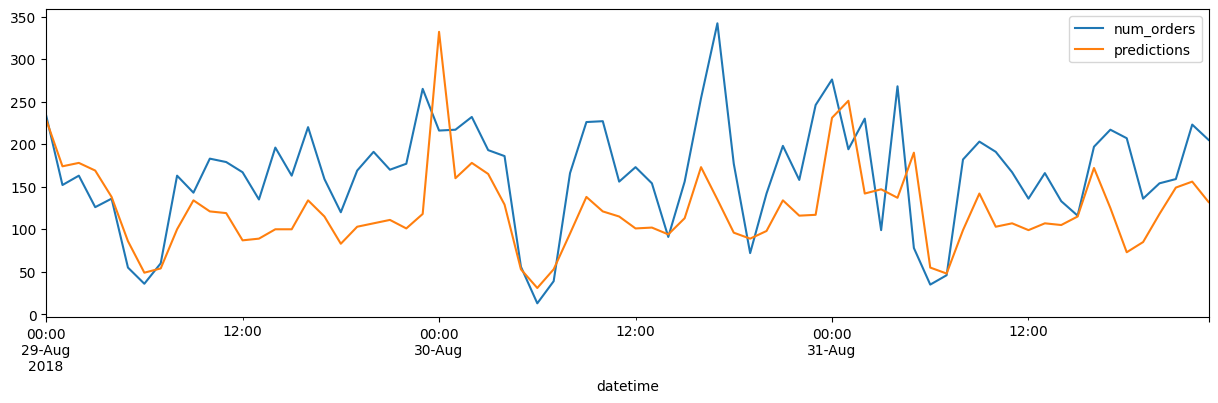

In [34]:
%%time

params = {'learning_rate':0.1,
          'depth': 4,
          'verbose':False,
          'random_state':15243}
best_model, best_model_rmse, best_model_time, best_pred_time = calculation('cbr',
                                                                           f_train,
                                                                           t_train,
                                                                           f_test,
                                                                           t_test,
                                                                           params,
                                                                           '2018-08-29',
                                                                           '2018-08-31',
                                                                           flag=True)

Feature Importance

In [35]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,8))
    
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + 'Важность признаков')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')

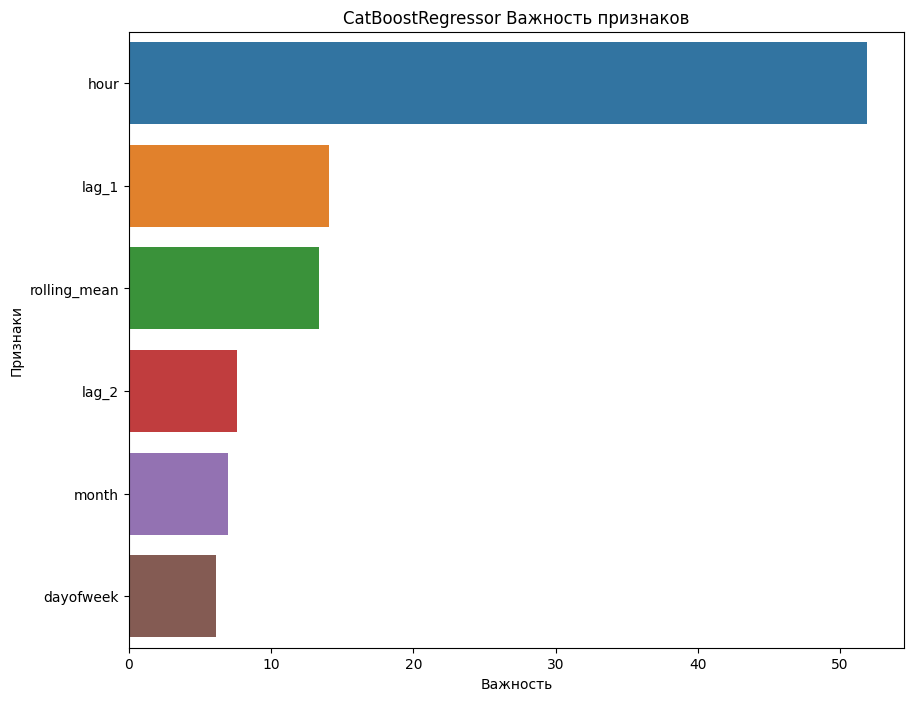

In [36]:
plot_feature_importance(best_model.feature_importances_, f_test.columns, 'CatBoostRegressor ')

Самым выжным признаком для построения модели оказался признак часа.

## Общий вывод

CatBoostRegressor показал лучший результат RMSE на обучающей выборке. Стоит отметить, что и остальные модели также показали удовлетворительный результат на обучающей выборке.

На тестовый данных показатель RMSE у CatBoostRegressor составил 46.602, что соответствует условию задачи.